# Converting depth images to point clouds using open3d
This notebook is the visual equivalent of the script `scripts/example.py`. 
Check the readme for more details.

In [1]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# point to the data dir
current_folder = Path(".").resolve()
base_dir = current_folder.parent / "data"

## Demo images
A single example of a tomato depth image is included. 

In [3]:
# point to the image files
image = "B_93dd57ad"        #B_93dd57ad B_0328ab97 A_1a111b40 D_b14ffae7

rgb_file = base_dir / "rgb" / f"{image}.png"
depth_file = base_dir / "depth" / f"{image}_depth.png"

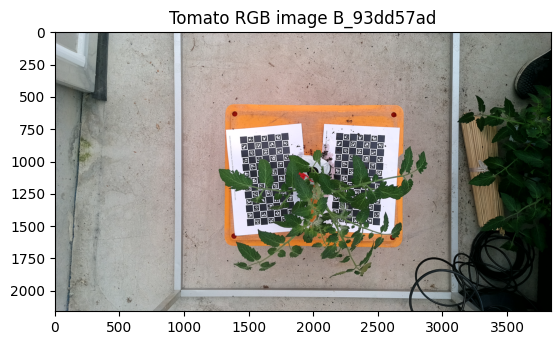

In [4]:
rgb_img = cv2.cvtColor(cv2.imread(str(rgb_file)), cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.title(f"Tomato RGB image {image}")
plt.show()

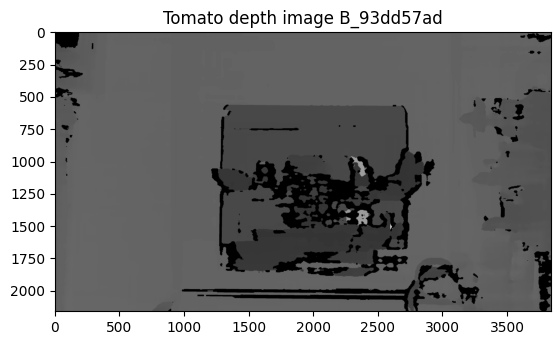

(2160, 3840)


In [5]:
# The depth image is provided by the camera, and is a reconstruction from stero infra-red imaging.
depth_img = cv2.imread(str(depth_file), cv2.IMREAD_UNCHANGED)
plt.imshow(depth_img, cmap='gray')
plt.title(f"Tomato depth image {image}")
plt.show()
print(depth_img.shape)

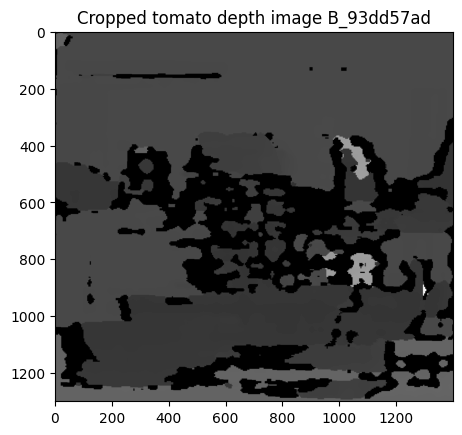

In [6]:
cropped_depth_img = depth_img[600:1900, 1300:2700]
plt.imshow(cropped_depth_img, cmap='gray')
plt.title(f"Cropped tomato depth image {image}")
plt.show()

In [7]:
import numpy as np
import cv2

# Load the depth image (replace 'depth.png' with your depth image)
depth = cropped_depth_img

# Define the camera intrinsic parameters
fx = 3090.78  # Focal length x
fy = 3090.78  # Focal length y
cx = 1883.67  # Optical center x
cy = 1066.81  # Optical center y

# Create a 3D point cloud
height, width = depth.shape
x = np.linspace(0, width - 1, width)
y = np.linspace(0, height - 1, height)
x, y = np.meshgrid(x, y)
x3 = (x - cx) * depth / fx
y3 = (y - cy) * depth / fy
z3 = depth
points3D = np.stack([x3, y3, z3], axis=-1)

# Now points3D is a 3D point cloud, where each point has x, y, and z coordinates
#print(points3D)
# points3D is a 3D numpy array with shape (height, width, 3)

min_x = np.min(points3D[:, :, 0])
print(f"min_x: {min_x}")
max_x = np.max(points3D[:, :, 0])
print(f"max_x: {max_x}")
min_y = np.min(points3D[:, :, 1])
print(f"min_y: {min_y}")
max_y = np.max(points3D[:, :, 1])
print(f"max_y: {max_y}")
min_z = np.min(points3D[:, :, 2])
print(f"min_z: {min_z}")
max_z = np.max(points3D[:, :, 2])
print(f"max_z: {max_z}")

range_x = max_x - min_x
range_y = max_y - min_y
range_z = max_z - min_z

print(f"range_x: {range_x}")
print(f"range_y: {range_y}")
print(f"range_z: {range_z}")



min_x: -967.1941354609515
max_x: -0.0
min_y: -564.2350862888978
max_y: 119.67162657969835
min_z: 0.0
max_z: 4076.0
range_x: 967.1941354609515
range_y: 683.9067128685962
range_z: 4076.0


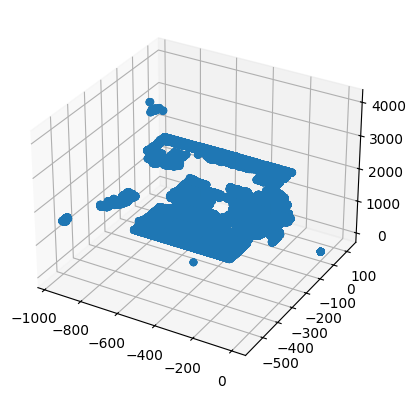

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Assuming points3D is a Nx3 numpy array
x = points3D[:, :, 0]
y = points3D[:, :, 1]
z = points3D[:, :, 2]

ax.scatter(x, y, z)
plt.show()

In [8]:
# point to the image files
image = "B_0328ab97"        #B_93dd57ad B_0328ab97 A_1a111b40 D_b14ffae7

rgb_file = base_dir / "rgb" / f"{image}.png"
depth_file = base_dir / "depth" / f"{image}_depth.png"
stereo_left_file = base_dir / "depth" / f"{image}_irL.png"
stereo_right_file = base_dir / "depth" / f"{image}_irR.png"

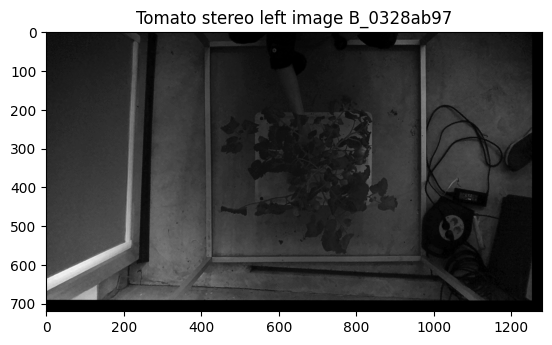

In [9]:
# The depth image is provided by the camera, and is a reconstruction from stero infra-red imaging.
stereo_left_img = cv2.imread(str(stereo_left_file), cv2.IMREAD_UNCHANGED)
plt.imshow(stereo_left_img, cmap='gray')
plt.title(f"Tomato stereo left image {image}")
plt.show()

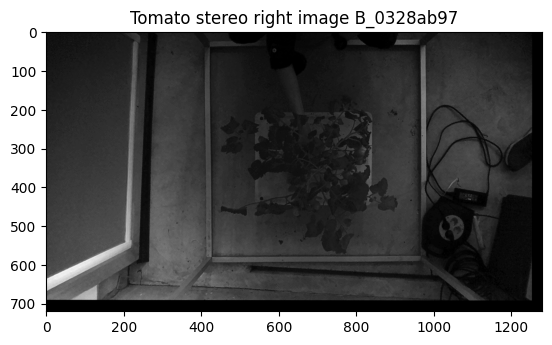

In [10]:
# The depth image is provided by the camera, and is a reconstruction from stero infra-red imaging.
stereo_right_img = cv2.imread(str(stereo_left_file), cv2.IMREAD_UNCHANGED)
plt.imshow(stereo_right_img, cmap='gray')
plt.title(f"Tomato stereo right image {image}")
plt.show()

In [11]:
import json
import logging
import time
from itertools import product
from pathlib import Path

import open3d as o3d

/Users/marcelviereck/Offline-Data/smart_tomAItoes/venv_tomato_2/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [12]:
class PointCloudCreator:
    """object to create a point cloud from a json file"""

    def __init__(
        self,
        conf_file: Path,
        logger_level: int = logging.DEBUG,
        logger_name: str = "point_cloud_creator",
    ) -> None:
        """Initialize the PointCloudCreator for a single camera, with constant configuration,
         to batch process depth images.

        Parameters
        ----------
        conf_file: Path
            location to the conf json with the camera intrinsics.
        logger_level: int, optional
            set log_level to 100 to supress all logging.
        logger_name: str, optional
            create a logger for writing outputs and debugging
        """
        # create logger
        logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s")
        self.logger = logging.getLogger(name=logger_name)
        self.logger.setLevel(logger_level)

        self.logger.info(f"Initialing point cloud creator from config file {conf_file}")

        # get camera settings from conf file
        self.settings = {}
        self.load_settings(conf_file=conf_file)

        # init a dummy placeholder to speed up the generation of images
        self.dummy_x = self.settings["x"]
        self.dummy_y = self.settings["y"]
        self.dummy_img = np.array(list(product(np.arange(0, self.dummy_y), np.arange(0, self.dummy_x))))
        self.dummy_index = np.zeros(self.dummy_x * self.dummy_y, np.float64)

    def load_settings(self, conf_file: Path) -> None:
        """Read and interpret the json config file of the camera.

        Parameters
        ----------
        conf_file: Path
            Json file with the camera intrinsics
        """
        with open(conf_file) as f:
            settings = json.loads(f.read())

        intrinsics, depth_scale, depth_trunc = self.set_intrinsics(settings)
        self.settings = {
            "intrinsics": intrinsics,
            "depth_scale": depth_scale,
            "depth_trunc": depth_trunc,
            "x": settings["color_int"]["width"],
            "y": settings["color_int"]["height"],
        }

    def set_intrinsics(self, settings: dict) -> (o3d.camera.PinholeCameraIntrinsic, float, float):
        """Set camera intrinsics from a dictionary

        Parameters
        ----------
        settings: dict
            dictionary of settings

        Returns
        -------
        o3d.camera.PinholeCameraIntrinsic:
            Intrinsics
        depth_scale: float
            See description in input args for o3d.geometry.RGBDImage().create_from_color_and_depth
        depth_trunc: float
            See description in input args for o3d.geometry.RGBDImage().create_from_color_and_depth
        """
        """converts json object to o3d pinhone camera model"""
        if "DepthScale" not in settings.keys():
            depth_scale = 1 / 1000
            self.logger.debug(f"DepthScale not found in conf, using default value ({depth_scale=}).")
        else:
            depth_scale = settings["DepthScale"]
        if "DepthTrunc" not in settings.keys():
            depth_trunc = 20000
            self.logger.debug(f"DepthTrunc not found in conf, using default value ({depth_trunc=}).")
        else:
            depth_trunc = settings["DepthTrunc"]

        intrinsics = o3d.camera.PinholeCameraIntrinsic(
            settings["color_int"]["width"],
            settings["color_int"]["height"],
            settings["color_int"]["fx"],
            settings["color_int"]["fy"],
            settings["color_int"]["ppx"],
            settings["color_int"]["ppy"],
        )

        return intrinsics, depth_scale, depth_trunc

    def convert_depth_to_pcd(
        self,
        rgb_file: Path,
        depth_file: Path,
    ) -> o3d.geometry.PointCloud:
        """Directly convert depth image to point cloud (pcd)
        This is faster than the custom approach via a points array, but open3d removes some points.

        Parameters
        ----------
        rgb_file: Path
            file to the color image
        depth_file: Path
            file to the depth image

        Returns
        -------
        point_cloud_object: o3d.geometry.PointCloud
            The point cloud as open3d object
        """
        t0 = time.time()
        self.logger.info(f"Converting depth image file {depth_file} to pcd.")

        # read images
        rgb_img = cv2.cvtColor(cv2.imread(str(rgb_file)), cv2.COLOR_BGR2RGB)
        depth_img = cv2.imread(str(depth_file), cv2.IMREAD_UNCHANGED)

        rgb_o3d = o3d.geometry.Image(np.ascontiguousarray(rgb_img).astype(np.uint8))
        depth_o3d = o3d.geometry.Image(np.ascontiguousarray(depth_img).astype(np.uint16))

        rgbd_image = o3d.geometry.RGBDImage().create_from_color_and_depth(
            color=rgb_o3d,
            depth=depth_o3d,
            convert_rgb_to_intensity=(len(rgb_img.shape) != 3),
            depth_trunc=self.settings["depth_trunc"],
            depth_scale=1 / self.settings["depth_scale"],
        )

        # extrinsic is the default argument. Providing it explicitly suppresses a warning.
        pcd = o3d.geometry.PointCloud().create_from_rgbd_image(
            image=rgbd_image,
            intrinsic=self.settings["intrinsics"],
            extrinsic=np.array(
                [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
            ),
        )

        self.logger.info(f"Generated pcd for {depth_file} in {time.time() - t0:.2f} seconds.")
        return pcd

    def convert_depth_to_point_array(self, depth_file: Path) -> np.array:
        """This is a custom version to reconstruct the point cloud. It is a bit slower but could useful
        if you want the point cloud to be exactly the same size as the image

        Parameters
        ----------
        depth_file: Path
            file to the depth image

        Returns
        -------
        points_array: np.array
            An array with x,y,z coordinates of each pixel.

        """
        t0 = time.time()
        self.logger.info(f"Converting depth image file {depth_file} to points array.")

        intrinsics = self.settings["intrinsics"]
        depth_scale = self.settings["depth_scale"]

        depth_img = cv2.imread(str(depth_file), cv2.IMREAD_UNCHANGED)

        # copy indexes
        y_index = self.dummy_img[:, 0].copy()
        x_index = self.dummy_img[:, 1].copy()

        # convert complete array no forloop needed. X en Y are vectors!
        Z = depth_scale * depth_img[y_index, x_index]
        X = self.dummy_index.copy()
        Y = self.dummy_index.copy()

        z_bool = Z != 0

        X[z_bool] = (
            Z[z_bool] * (x_index[z_bool] - intrinsics.get_principal_point()[0]) / intrinsics.get_focal_length()[0]
        )
        Y[z_bool] = (
            Z[z_bool] * (y_index[z_bool] - intrinsics.get_principal_point()[1]) / intrinsics.get_focal_length()[1]
        )

        points_array = np.array([X, Y, Z], dtype=np.float64).transpose()
        self.logger.info(
            f"Generated points array of {len(points_array)=} for {depth_file} in {time.time() - t0:.2f} seconds."
        )

        return points_array

In [13]:
def write_pcd(
    pcd: o3d.geometry.PointCloud,
    pcd_file: Path or str,
    down_sample: bool = False,
    down_factor: int = 9,
) -> None:
    """Writes the open3d point cloud to a file

    Parameters
    ----------
    pcd: o3d.geometry.PointCloud
        The point cloud as open3d object
    pcd_file: Path
    down_sample: bool
        Naively Discard a fraction of the points to reduce the point cloud size.
    down_factor: int
        number of points to keep. e.g., it keeps 1 out of down_factor points.
    """
    if down_sample:
        pcd = pcd.select_by_index(range(0, len(pcd.points), down_factor))
    o3d.io.write_point_cloud(str(pcd_file), pcd, write_ascii=False, compressed=True)


def create_pcd_from_array(
    rgb_file: Path,
    points_array: np.array,
) -> o3d.geometry.PointCloud:
    """Convert point array (output of convert_depth_to_point_array) to an open3d pcd object.
    Note: this step is relatively slow.

    Parameters
    ----------
    rgb_file: Path
        file to the color image
    points_array: np.array
        the point array (output of convert_depth_to_point_array)

    Returns
    -------
    point_cloud_object: o3d.geometry.PointCloud
        The point cloud as open3d object
    """
    rgb_img = cv2.cvtColor(cv2.imread(str(rgb_file)), cv2.COLOR_BGR2RGB)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    pcd.colors = o3d.utility.Vector3dVector(np.reshape(rgb_img, (rgb_img.shape[0] * rgb_img.shape[1], 3)) / 255.0)
    return pcd


def read_pcd(file_name: Path) -> o3d.geometry.PointCloud:
    """Reads a point cloud file (.pcd)

    Parameters
    ----------
    file_name: Path
        The path of the pcd file

    Returns
    -------
    pcd: o3d.geometry.PointCloud
        The point cloud as open3d object
    """
    if not file_name.is_file():
        raise Exception(f"{file_name} is not a file")
    return o3d.io.read_point_cloud(str(file_name))


In [16]:

"""Demo script that read the image in data/depth + data/rgb and outputs a pcd file in data/pointclouds
with the same name, in two different ways."""

# point to the data dir, relative from this script folder
current_folder = Path(__file__).resolve().parent
base_dir = current_folder.parent / "data"

# init a point cloud creator with the camera configuration
point_cloud_creator = PointCloudCreator(conf_file=base_dir / "oak-d-s2-poe_conf.json")

# point to the image files
image = "A_1a111b40"
rgb_file = base_dir / "rgb" / f"{image}.png"
depth_file = base_dir / "depth" / f"{image}_depth.png"

#
# First approach, Using open3d fully. Is faster but will remove some points
#
out_file = base_dir / "pointclouds" / f"{image}_open3d.pcd"
out_file.parent.mkdir(parents=True, exist_ok=True)
out_file.unlink(missing_ok=True)

# create pcd object
pcd_object2 = point_cloud_creator.convert_depth_to_pcd(rgb_file=rgb_file, depth_file=depth_file)

# write the (down-sampled) pcd object to file
write_pcd(pcd=pcd_object2, pcd_file=out_file, down_sample=False, down_factor=9)

# now check that we can read it again
pcd_object = read_pcd(out_file)
assert pcd_object is not None

#
# Second approach, a bit faster and more configurable.
#
out_file2 = base_dir / "pointclouds" / f"{image}.pcd"
out_file2.unlink(missing_ok=True)
out_file2.parent.mkdir(parents=True, exist_ok=True)

# Start by converting depth image to point array
points_array = point_cloud_creator.convert_depth_to_point_array(depth_file=depth_file)

# Now create open3d point cloud file (.pcd). This is quite slow.
pcd_object2 = create_pcd_from_array(rgb_file=rgb_file, points_array=points_array)

# write the (down-sampled) pcd object to file
write_pcd(pcd=pcd_object2, pcd_file=out_file2, down_sample=False, down_factor=9)

# now check that we can read it again
pcd_object2 = read_pcd(out_file2)
assert pcd_object2 is not None

NameError: name '__file__' is not defined

NameError: name '__file__' is not defined